<a href="https://colab.research.google.com/github/SalhaAlzahrani/KD_TripartiteAtten/blob/main/_KonwledgeDistillation_TransfomerTripartite_II.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🟢  Knowledge Distillation in Transformers with Tripartite Attention: Multiclass Brain Tumor Detection in Highly Augmented MRIs


In [ ]:
!pip install -U -q tensorflow-addons
!pip install nest_asyncio
!pip install keras-cv tensorflow --upgrade

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
import tensorflow_addons as tfa
from keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow_hub as hub
import tensorflow_datasets as tfds
import pathlib
import glob
import keras_cv
import os
from sklearn.utils.class_weight import compute_class_weight
from sklearn.utils import class_weight
import math

from google.colab import drive
# Define the path to the MRI data directory
drive.mount('/content/drive', force_remount=True)

import nest_asyncio

## Hyperparameters

In [ ]:
IMG_SIZE = 224 # We'll resize input images to this size.
input_shape = (224, 224, 3)
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 64
num_epochs = 100
dropout_rate = 0.2
# DATA
BUFFER_SIZE = 512
BATCH_SIZE = 256
# AUGMENTATION
PATCH_SIZE = 6
NUM_PATCHES = (IMG_SIZE // PATCH_SIZE) ** 2
# ARCHITECTURE
LAYER_NORM_EPS = 1e-6
TRANSFORMER_LAYERS = 8
PROJECTION_DIM = 64
NUM_HEADS = 4
TRANSFORMER_UNITS = [
    PROJECTION_DIM * 2,
    PROJECTION_DIM,
]
MLP_HEAD_UNITS = [2048, 1024]

In [ ]:
def plot_training_curves(history, title, model_name=''):
    if (model_name == 'teacher'):
      loss = np.array(history.history['loss'])
      val_loss = np.array(history.history['val_loss'])
      epochs = range(len(history.history['loss']))
    else:
      loss = np.array(history.history['student_loss'])
      val_loss = np.array(history.history['val_student_loss'])
      epochs = range(len(history.history['student_loss']))
    accuracy = np.array(history.history['accuracy'])
    val_accuracy = np.array(history.history['val_accuracy'])

    plt.style.use('fivethirtyeight')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
    fig.patch.set_facecolor('xkcd:white')

    # Plot loss
    ax1.plot(epochs, loss, label='training_loss', marker='.', )
    ax1.plot(epochs, val_loss, label='val_loss', marker='.', )
    ax1.fill_between(epochs, loss, val_loss, where=(loss > val_loss), color='C0', alpha=0.3, interpolate=True)
    ax1.fill_between(epochs, loss, val_loss, where=(loss < val_loss), color='C1', alpha=0.3, interpolate=True)
    ax1.set_title('Loss: '+title, fontsize=16)
    ax1.set_xlabel('Epochs', fontsize=14)
    ax1.legend()

    # Plot accuracy
    ax2.set_ylim(ymin=0, ymax=1.1)
    ax2.plot(epochs, accuracy, label='training_accuracy', marker='.')
    ax2.plot(epochs, val_accuracy, label='val_accuracy', marker='.')
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy > val_accuracy), color='C0', alpha=0.3, interpolate=True)
    ax2.fill_between(epochs, accuracy, val_accuracy, where=(accuracy < val_accuracy), color='C1', alpha=0.3, interpolate=True)
    ax2.set_title('Accuracy: '+title, fontsize=16)
    ax2.set_xlabel('Epochs', fontsize=14)
    ax2.legend()

In [ ]:
def visualize_dataset(dataset, title):
  plt.figure(figsize=(10, 10)).suptitle(title, fontsize=18)
  for images, labels in iter(dataset.take(9)):
    for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      img = tf.image.rgb_to_grayscale(images[i])
      plt.imshow(img, cmap='bone')
      ax.grid()
      plt.axis("off")

# Construct Distiller() class





In [ ]:
class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super().__init__()
        self.teacher = teacher
        self.student = student
    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):
        """ Configure the distiller.
        Args:
            optimizer: Keras optimizer for the student weights
            metrics: Keras metrics for evaluation
            student_loss_fn: Loss function of difference between student
                predictions and ground-truth
            distillation_loss_fn: Loss function of difference between soft
                student predictions and soft teacher predictions
            alpha: weight to student_loss_fn and 1-alpha to distillation_loss_fn
            temperature: Temperature for softening probability distributions.
                Larger temperature gives softer distributions.
        """
        super().compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack data
        #x, y = data
        x = data[:][0] # get the 0th column of all rows
        y = data[:][1] # get the 1st column of all rows
        # Forward pass of teacher
        teacher_predictions = self.teacher(x, training=False)
        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predictions = self.student(x, training=True)
            # Compute losses
            student_loss = self.student_loss_fn(y, student_predictions)
            # Compute scaled distillation loss from https://arxiv.org/abs/1503.02531
            # The magnitudes of the gradients produced by the soft targets scale
            # as 1/T^2, multiply them by T^2 when using both hard and soft targets.
            distillation_loss = (
                self.distillation_loss_fn(
                    tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                    tf.nn.softmax(student_predictions / self.temperature, axis=1),
                )
                * self.temperature**2
            )
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss
        # Compute gradients
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update the metrics configured in `compile()`.
        self.compiled_metrics.update_state(y, student_predictions)
        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update(
            {"student_loss": student_loss, "distillation_loss": distillation_loss}
        )
        return results

    def test_step(self, data):
        # Unpack the data
        #x, y = data
        x = data[:][0] # get the 0th column of all rows
        y = data[:][1] # get the 1st column of all rows
        # Compute predictions
        y_prediction = self.student(x, training=False)
        # Calculate the loss
        student_loss = self.student_loss_fn(y, y_prediction)
        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)
        # Return a dict of performance
        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

#run_experiment module

In [ ]:
from keras.src.callbacks import LearningRateScheduler
def run_experiment(training_dataset, validation_dataset, model, model_name=''):
    # Create LAMB optimizer with weight decay.
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    # Compile the model.
    if(model_name == 'teacher'):
      model.compile(
          optimizer=optimizer,
          loss=keras.losses.CategoricalCrossentropy(from_logits=True),
          metrics=[
              keras.metrics.CategoricalAccuracy(name="accuracy"),
              keras.metrics.TopKCategoricalAccuracy(5, name="top5-acc"),
              keras.metrics.MeanSquaredError(name='Brier score'),
              keras.metrics.AUC(name='auc'),
          ],
      )
      # Create a learning rate scheduler callback.
      reduce_lr = keras.callbacks.ReduceLROnPlateau(
          monitor="val_loss", factor=0.2, patience=3
      )
      # Create an early stopping callback.
      early_stopping = tf.keras.callbacks.EarlyStopping(
          monitor="val_loss", patience=15, restore_best_weights=True
      )
    else:
      distiller.compile(
          optimizer=keras.optimizers.Adam(),
          metrics=[
              keras.metrics.CategoricalAccuracy(name="accuracy"),
              keras.metrics.TopKCategoricalAccuracy(5, name="top5-acc"),
              keras.metrics.MeanSquaredError(name='Brier score'),
              keras.metrics.AUC(name='auc'),
          ],
          student_loss_fn=keras.losses.CategoricalCrossentropy(from_logits=True),
          distillation_loss_fn=keras.losses.KLDivergence(),
          alpha=0.1,
          temperature=10,
      )
      # Create a learning rate scheduler callback.
      reduce_lr = keras.callbacks.ReduceLROnPlateau(
          monitor="student_loss", factor=0.2, patience=3
      )
      # Create an early stopping callback.
      early_stopping = tf.keras.callbacks.EarlyStopping(
          monitor="student_loss", patience=15, restore_best_weights=True
      )

    # Fit the model.
    history = model.fit(
        training_dataset,
        validation_data = validation_dataset,
        batch_size=batch_size,
        epochs=num_epochs,
        class_weight=class_weights_dict,
        callbacks=[early_stopping, reduce_lr],
    )
    # Return history to plot learning curves.
    return history

# 🔴 Transformer



In [ ]:
class ShiftedPatchTokenization(layers.Layer):
    def __init__(
        self,
        image_size=IMG_SIZE,
        patch_size=PATCH_SIZE,
        num_patches=NUM_PATCHES,
        projection_dim=PROJECTION_DIM,
        vanilla=False,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.vanilla = vanilla  # Flag to swtich to vanilla patch extractor
        self.image_size = image_size
        self.patch_size = patch_size
        self.half_patch = patch_size // 2
        self.flatten_patches = layers.Reshape((num_patches, -1))
        self.projection = layers.Dense(units=projection_dim)
        self.layer_norm = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)

    def crop_shift_pad(self, images, mode):
        # Build the diagonally shifted images
        if mode == "left-up":
            crop_height = self.half_patch
            crop_width = self.half_patch
            shift_height = 0
            shift_width = 0
        elif mode == "left-down":
            crop_height = 0
            crop_width = self.half_patch
            shift_height = self.half_patch
            shift_width = 0
        elif mode == "right-up":
            crop_height = self.half_patch
            crop_width = 0
            shift_height = 0
            shift_width = self.half_patch
        else:
            crop_height = 0
            crop_width = 0
            shift_height = self.half_patch
            shift_width = self.half_patch

        # Crop the shifted images and pad them
        crop = tf.image.crop_to_bounding_box(
            images,
            offset_height=crop_height,
            offset_width=crop_width,
            target_height=self.image_size - self.half_patch,
            target_width=self.image_size - self.half_patch,
        )
        shift_pad = tf.image.pad_to_bounding_box(
            crop,
            offset_height=shift_height,
            offset_width=shift_width,
            target_height=self.image_size,
            target_width=self.image_size,
        )
        return shift_pad

    def call(self, images):
        if not self.vanilla:
            # Concat the shifted images with the original image
            images = tf.concat(
                [
                    images,
                    self.crop_shift_pad(images, mode="left-up"),
                    self.crop_shift_pad(images, mode="left-down"),
                    self.crop_shift_pad(images, mode="right-up"),
                    self.crop_shift_pad(images, mode="right-down"),
                ],
                axis=-1,
            )
        # Patchify the images and flatten it
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        flat_patches = self.flatten_patches(patches)
        if not self.vanilla:
            # Layer normalize the flat patches and linearly project it
            tokens = self.layer_norm(flat_patches)
            tokens = self.projection(tokens)
        else:
            # Linearly project the flat patches
            tokens = self.projection(flat_patches)
        return (tokens, patches)

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(
        self, num_patches=NUM_PATCHES, projection_dim=PROJECTION_DIM, **kwargs
    ):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
        self.positions = tf.range(start=0, limit=self.num_patches, delta=1)

    def call(self, encoded_patches):
        encoded_positions = self.position_embedding(self.positions)
        encoded_patches = encoded_patches + encoded_positions
        return encoded_patches

In [ ]:
class MultiHeadAttentionLSA(tf.keras.layers.MultiHeadAttention):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        # The trainable temperature term. The initial value is
        # the square root of the key dimension.
        self.tau = tf.Variable(math.sqrt(float(self._key_dim)), trainable=True)

    def _compute_attention(self, query, key, value, attention_mask=None, training=None):
        query = tf.multiply(query, 1.0 / self.tau)
        attention_scores = tf.einsum(self._dot_product_equation, key, query)
        attention_scores = self._masked_softmax(attention_scores, attention_mask)
        attention_scores_dropout = self._dropout_layer(
            attention_scores, training=training
        )
        attention_output = tf.einsum(
            self._combine_equation, attention_scores_dropout, value
        )
        return attention_output, attention_scores

In [ ]:
class BaseAttention(tf.keras.layers.Layer):
    """
    Base class for all attention layers. It contains the common functionality of all attention layers.
    This layer contains a MultiHeadAttention layer, a LayerNormalization layer and an Add layer.
    It is used as a base class for the GlobalSelfAttention, CausalSelfAttention and CrossAttention layers.
    And it is not intended to be used directly.
    Attributes:
        mha (tf.keras.layers.MultiHeadAttention): The MultiHeadAttention layer.
        layernorm (tf.keras.layers.LayerNormalization): The LayerNormalization layer.
        add (tf.keras.layers.Add): The Add layer.
    """
    def __init__(self, **kwargs: dict):
        """ Constructor of the BaseAttention layer.
        Args:
            **kwargs: Additional keyword arguments that are passed to the MultiHeadAttention layer, e. g.
                        num_heads (number of heads), key_dim (dimensionality of the key space), etc.
        """
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

class CrossAttention(BaseAttention):
    """
    A class that implements the cross-attention layer by inheriting from the BaseAttention class.
    This layer is used to process two different sequences and attends to the context sequence while processing the query sequence.
    Attributes:
        mha (tf.keras.layers.MultiHeadAttention): The MultiHeadAttention layer.
        layernorm (tf.keras.layers.LayerNormalization): The LayerNormalization layer.
        add (tf.keras.layers.Add): The Add layer.
    """
    def call(self, x: tf.Tensor, context: tf.Tensor) -> tf.Tensor:
        """
        The call function that performs the cross-attention operation.
        Args:
            x (tf.Tensor): The query (expected Transformer results) sequence of shape (batch_size, seq_length, d_model).
            context (tf.Tensor): The context (inputs to the Encoder layer) sequence of shape (batch_size, seq_length, d_model).
        Returns:
            tf.Tensor: The output sequence of shape (batch_size, seq_length, d_model).
        """
        attn_output, attn_scores = self.mha(query=x, key=context, value=context, return_attention_scores=True)
        # Cache the attention scores for plotting later.
        self.last_attn_scores = attn_scores
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

class GlobalSelfAttention(BaseAttention):
    """
    A class that implements the global self-attention layer by inheriting from the BaseAttention class.
    This layer is used to process a single sequence and attends to all the tokens in the sequence.
    Attributes:
        mha (tf.keras.layers.MultiHeadAttention): The MultiHeadAttention layer.
        layernorm (tf.keras.layers.LayerNormalization): The LayerNormalization layer.
        add (tf.keras.layers.Add): The Add layer.
    """
    def call(self, x: tf.Tensor) -> tf.Tensor:
        """
        The call function that performs the global self-attention operation.
        Args:
            x (tf.Tensor): The input sequence of shape (batch_size, seq_length, d_model).
        Returns:
            tf.Tensor: The output sequence of shape (batch_size, seq_length, d_model).
        """
        attn_output = self.mha(query=x, value=x, key=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

In [ ]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x
# Build the diagonal attention mask
diag_attn_mask = 1 - tf.eye(NUM_PATCHES)
diag_attn_mask = tf.cast([diag_attn_mask], dtype=tf.int8)

In [ ]:
def create_transfomer(vanilla=False):
    inputs = layers.Input(shape=input_shape)

    # Create patches.
    (tokens, _) = ShiftedPatchTokenization(vanilla=vanilla)(inputs)
    # Encode patches.
    encoded_patches = PatchEncoder()(tokens)

    # Create multiple layers of the Transformer block.
    for _ in range(TRANSFORMER_LAYERS):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # slef locality attention layer
        attention_output = MultiHeadAttentionLSA(
            num_heads=NUM_HEADS, key_dim=PROJECTION_DIM, dropout=0.1
        )(x1, x1, attention_mask=diag_attn_mask)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=TRANSFORMER_UNITS, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches_1 = layers.Add()([x3, x2])
        #####################################################################
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches_1)
        # Global attention layer
        attention_output = GlobalSelfAttention(
            num_heads=NUM_HEADS, key_dim=PROJECTION_DIM
        )(x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches_1])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=TRANSFORMER_UNITS, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches_2 = layers.Add()([x3, x2])
        #####################################################################
        # Cross attention layer
        attention_output = CrossAttention(
            num_heads=NUM_HEADS, key_dim=PROJECTION_DIM
        )(encoded_patches_1, encoded_patches_2)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches_2])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=TRANSFORMER_UNITS, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=MLP_HEAD_UNITS, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(NUM_CLASSES)(features)

    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model



---



# 📂 Load BTDS-17C

In [ ]:
##################
NUM_CLASSES = 17
##################
path = '/content/drive/MyDrive/Multiclass_Brain_Tumor_MRI/MRI_17Classes/'
# train data
train_ds = image_dataset_from_directory(
    directory= path,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(IMG_SIZE,IMG_SIZE),
    color_mode='rgb',
    #shuffle=True,
    seed=128,
    validation_split=0.2,
    subset='training',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)
# validation data
val_ds = image_dataset_from_directory(
    directory= path,
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(IMG_SIZE,IMG_SIZE),
    color_mode='rgb',
    #shuffle=True,
    seed=128,
    validation_split=0.2,
    subset='validation',
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)
#Configure the dataset for performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

Found 4415 files belonging to 17 classes.
Using 3532 files for training.
Found 4415 files belonging to 17 classes.
Using 883 files for validation.


## ◼ Class Weighting

In [ ]:
#label_mode='categorical',
train_ds_cat = image_dataset_from_directory(
    directory= path,
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(IMG_SIZE,IMG_SIZE),
)
class_names = train_ds_cat.class_names
num_images_per_class = []
for label in class_names:
    dir_name = path + label
    num_images_per_class.append(len([name for name in os.listdir(dir_name)]))
# y_train=list of train labels wrt to given directory format
y_train=[]
for i in range(0, len(num_images_per_class)):
    y_train+=[i]*num_images_per_class[i]
classes = list()
for i in range(NUM_CLASSES): classes.append(i)
class_weights=compute_class_weight(class_weight="balanced",classes=classes, y=np.asarray(y_train))
class_weights_dict = {}
for i in range(len(class_weights)):
   class_weights_dict[i] = class_weights[i]
class_weights_dict

Found 4415 files belonging to 17 classes.


{0: 0.5700371651928745,
 1: 0.5110294117647058,
 2: 0.7562053723223393,
 3: 0.7583972719522591,
 4: 0.41863529411764705,
 5: 0.7952798140532809,
 6: 0.9619377162629758,
 7: 0.8991307863351526,
 8: 1.5482074486599373,
 9: 1.0024791525805725,
 10: 2.3361344537815127,
 11: 1.721362229102167,
 12: 5.450980392156863,
 13: 4.590299277605779,
 14: 1.7101114955786236,
 15: 1.348696179502729,
 16: 2.127211860353898}

# 🅰 Data augmentation

In the original paper, the authors use AutoAugment to induce stronger regularization. For this example, we will be using the standard geometric augmentations like random cropping and flipping. https://arxiv.org/abs/1805.09501

In [ ]:
def to_dict(image, label):
    image = tf.cast(image, tf.float32)
    label = tf.one_hot(label, NUM_CLASSES)
    return {"images": image, "labels": label}

def preprocess_for_model(inputs):
    images, labels = inputs["images"], inputs["labels"]
    images = tf.cast(images, tf.float32)
    return images, labels

augmix = keras_cv.layers.AugMix([0, 255])
mixup = keras_cv.layers.MixUp()
cutmix = keras_cv.layers.CutMix(alpha=0.02)

#No augmentation
train_ds_v = train_ds.map(to_dict)
train_ds_v = train_ds_v.map(preprocess_for_model, num_parallel_calls=AUTOTUNE)
train_ds_v = train_ds_v.prefetch(AUTOTUNE)
val_ds_v = val_ds.map(to_dict)
val_ds_v = val_ds_v.map(preprocess_for_model, num_parallel_calls=AUTOTUNE)
val_ds_v = val_ds_v.prefetch(AUTOTUNE) #Use this for fit

In [ ]:
def aug_pipeline1(samples):
    samples = augmix(samples, training=True)
    return samples
def aug_pipeline2(samples):
    samples = mixup(samples, training=True)
    return samples
def aug_pipeline3(samples):
    samples = cutmix(samples, training=True)
    return samples
def aug_pipeline(samples):
    samples = augmix(samples, training=True)
    samples = mixup(samples, training=True)
    samples = cutmix(samples, training=True)
    return samples
#AugMix
augmix_ds = train_ds.shuffle(1000).map(to_dict)
augmix_ds = augmix_ds.map(aug_pipeline1)
augmix_ds = augmix_ds.map(preprocess_for_model, num_parallel_calls=AUTOTUNE)
augmix_ds = augmix_ds.prefetch(AUTOTUNE) #Use this for fit
#MixUp
mixup_ds = train_ds.shuffle(1000).map(to_dict)
mixup_ds = mixup_ds.map(aug_pipeline2)
mixup_ds = mixup_ds.map(preprocess_for_model, num_parallel_calls=AUTOTUNE)
mixup_ds = mixup_ds.prefetch(AUTOTUNE) #Use this for fit
#CutMix
cutmix_ds = train_ds.shuffle(1000).map(to_dict)
cutmix_ds = cutmix_ds.map(aug_pipeline3)
cutmix_ds = cutmix_ds.map(preprocess_for_model, num_parallel_calls=AUTOTUNE)
cutmix_ds = cutmix_ds.prefetch(AUTOTUNE) #Use this for fit
#AugPip
augpip_ds = train_ds.shuffle(1000).map(to_dict)
augpip_ds = augpip_ds.map(aug_pipeline)
augpip_ds = augpip_ds.map(preprocess_for_model, num_parallel_calls=AUTOTUNE)
augpip_ds = augpip_ds.prefetch(AUTOTUNE) #Use this for fit

## Create student and teacher models




In [ ]:
TRANSFORMER_LAYERS = 4
NUM_HEADS = 2
transformer_teacher = create_transfomer()
#####################################################
TRANSFORMER_LAYERS = 2
NUM_HEADS = 2
transformer_student = create_transfomer()

### ▶ No Aug



In [ ]:
history = run_experiment(train_ds_v, val_ds_v, transformer_teacher, model_name='teacher')

Epoch 1/100
111/111 [==============================] - 327s 3s/step - loss: 7.8751 - accuracy: 0.2409 - top5-acc: 0.5796 - Brier score: 63.9533 - auc: 0.6472 - val_loss: 1.9124 - val_accuracy: 0.4371 - val_top5-acc: 0.7735 - val_Brier score: 7.1275 - val_auc: 0.7681 - lr: 0.0010
Epoch 2/100
111/111 [==============================] - 31s 274ms/step - loss: 2.2908 - accuracy: 0.4485 - top5-acc: 0.8083 - Brier score: 28.7248 - auc: 0.7520 - val_loss: 1.5554 - val_accuracy: 0.5323 - val_top5-acc: 0.8573 - val_Brier score: 7.7563 - val_auc: 0.8024 - lr: 0.0010
Epoch 3/100
111/111 [==============================] - 31s 274ms/step - loss: 1.5521 - accuracy: 0.5756 - top5-acc: 0.8805 - Brier score: 29.9704 - auc: 0.7809 - val_loss: 1.2205 - val_accuracy: 0.6546 - val_top5-acc: 0.9320 - val_Brier score: 8.4095 - val_auc: 0.8602 - lr: 0.0010
Epoch 4/100
111/111 [==============================] - 31s 275ms/step - loss: 1.0151 - accuracy: 0.6874 - top5-acc: 0.9411 - Brier score: 46.0579 - auc: 0.7

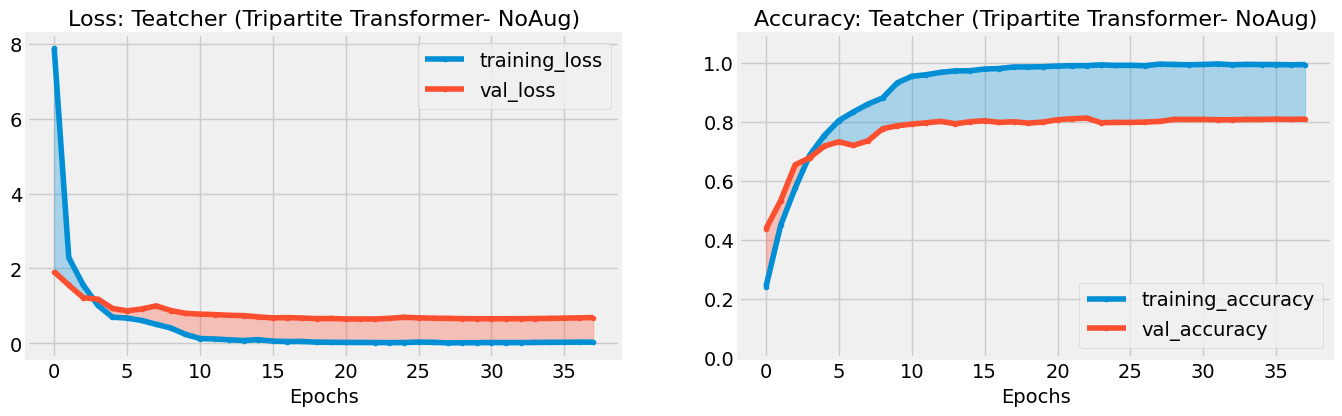

In [ ]:
plot_training_curves(history, 'Teatcher (Tripartite Transformer- NoAug)', model_name='teacher')

In [ ]:
distiller = Distiller(student=transformer_student, teacher=transformer_teacher)
history = run_experiment(train_ds_v, val_ds_v, distiller, model_name='distiller')

Epoch 1/100
111/111 [==============================] - 52s 254ms/step - accuracy: 0.3012 - top5-acc: 0.6843 - Brier score: 38.1623 - auc: 0.7009 - student_loss: 4.9518 - distillation_loss: 32.7065 - val_accuracy: 0.5549 - val_top5-acc: 0.8879 - val_Brier score: 10.5666 - val_auc: 0.8360 - val_student_loss: 1.2253 - lr: 0.0010
Epoch 2/100
111/111 [==============================] - 26s 236ms/step - accuracy: 0.5156 - top5-acc: 0.8635 - Brier score: 39.0830 - auc: 0.7986 - student_loss: 2.0731 - distillation_loss: 18.4836 - val_accuracy: 0.6263 - val_top5-acc: 0.9060 - val_Brier score: 12.9058 - val_auc: 0.8585 - val_student_loss: 0.8448 - lr: 0.0010
Epoch 3/100
111/111 [==============================] - 26s 236ms/step - accuracy: 0.6518 - top5-acc: 0.9343 - Brier score: 42.3694 - auc: 0.8339 - student_loss: 1.3055 - distillation_loss: 13.3764 - val_accuracy: 0.6818 - val_top5-acc: 0.9320 - val_Brier score: 11.1258 - val_auc: 0.8839 - val_student_loss: 1.1296 - lr: 0.0010
Epoch 4/100
111/

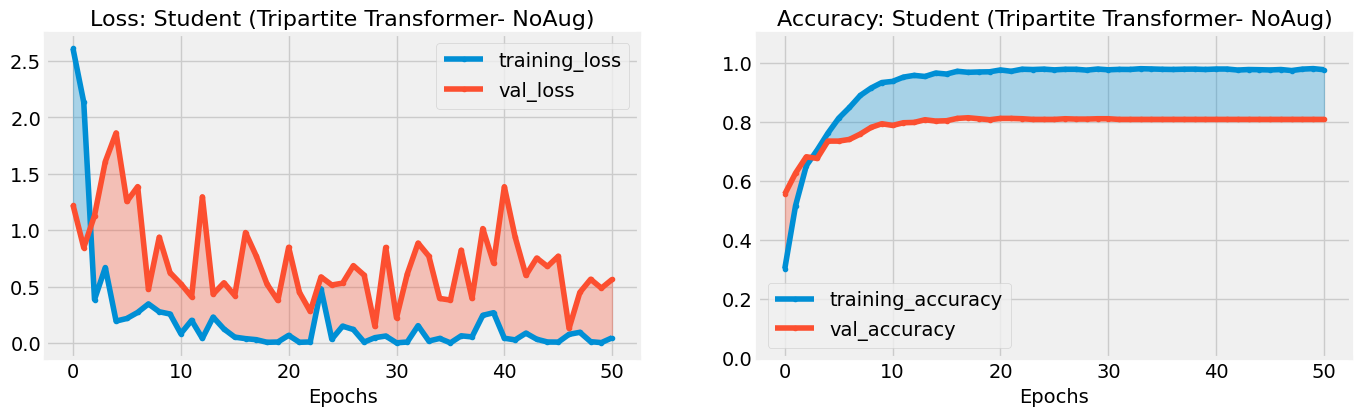

In [ ]:
plot_training_curves(history, 'Student (Tripartite Transformer- NoAug)', model_name='student')

### ▶ AugMix







In [ ]:
history = run_experiment(augmix_ds, val_ds_v, transformer_teacher, model_name='teacher')

Epoch 1/100
111/111 [==============================] - 95s 652ms/step - loss: 7.8052 - accuracy: 0.1659 - top5-acc: 0.4915 - Brier score: 43.4158 - auc: 0.6121 - val_loss: 2.0581 - val_accuracy: 0.3862 - val_top5-acc: 0.7475 - val_Brier score: 2.9171 - val_auc: 0.7833 - lr: 0.0010
Epoch 2/100
111/111 [==============================] - 76s 663ms/step - loss: 2.7546 - accuracy: 0.2857 - top5-acc: 0.6552 - Brier score: 10.8320 - auc: 0.7050 - val_loss: 2.1070 - val_accuracy: 0.3556 - val_top5-acc: 0.7101 - val_Brier score: 3.0957 - val_auc: 0.7648 - lr: 0.0010
Epoch 3/100
111/111 [==============================] - 76s 660ms/step - loss: 2.1054 - accuracy: 0.3505 - top5-acc: 0.7109 - Brier score: 11.1112 - auc: 0.7360 - val_loss: 1.7004 - val_accuracy: 0.4915 - val_top5-acc: 0.8211 - val_Brier score: 6.3075 - val_auc: 0.8155 - lr: 0.0010
Epoch 4/100
111/111 [==============================] - 76s 665ms/step - loss: 1.8884 - accuracy: 0.4054 - top5-acc: 0.7681 - Brier score: 13.5104 - auc: 0

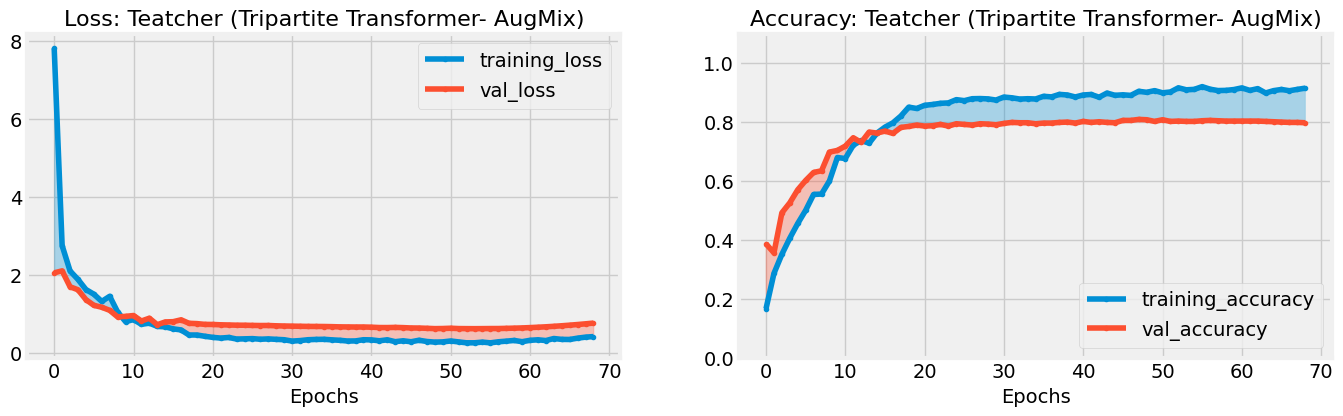

In [ ]:
plot_training_curves(history, 'Teatcher (Tripartite Transformer- AugMix)', model_name='teacher')

In [ ]:
distiller = Distiller(student=transformer_student, teacher=transformer_teacher)
history = run_experiment(augmix_ds, val_ds_v, distiller, model_name='distiller')

Epoch 1/100
111/111 [==============================] - 93s 603ms/step - accuracy: 0.2126 - top5-acc: 0.5742 - Brier score: 14.9098 - auc: 0.6469 - student_loss: 3.8863 - distillation_loss: 10.3388 - val_accuracy: 0.3907 - val_top5-acc: 0.7724 - val_Brier score: 1.6901 - val_auc: 0.7951 - val_student_loss: 1.8575 - lr: 0.0010
Epoch 2/100
111/111 [==============================] - 75s 651ms/step - accuracy: 0.3177 - top5-acc: 0.6985 - Brier score: 6.7583 - auc: 0.7341 - student_loss: 2.2856 - distillation_loss: 6.0549 - val_accuracy: 0.4519 - val_top5-acc: 0.8562 - val_Brier score: 3.4333 - val_auc: 0.8446 - val_student_loss: 1.7579 - lr: 0.0010
Epoch 3/100
111/111 [==============================] - 74s 645ms/step - accuracy: 0.3751 - top5-acc: 0.7387 - Brier score: 7.0982 - auc: 0.7535 - student_loss: 2.0844 - distillation_loss: 5.3994 - val_accuracy: 0.4960 - val_top5-acc: 0.8562 - val_Brier score: 3.0115 - val_auc: 0.8332 - val_student_loss: 2.0192 - lr: 0.0010
Epoch 4/100
111/111 [==

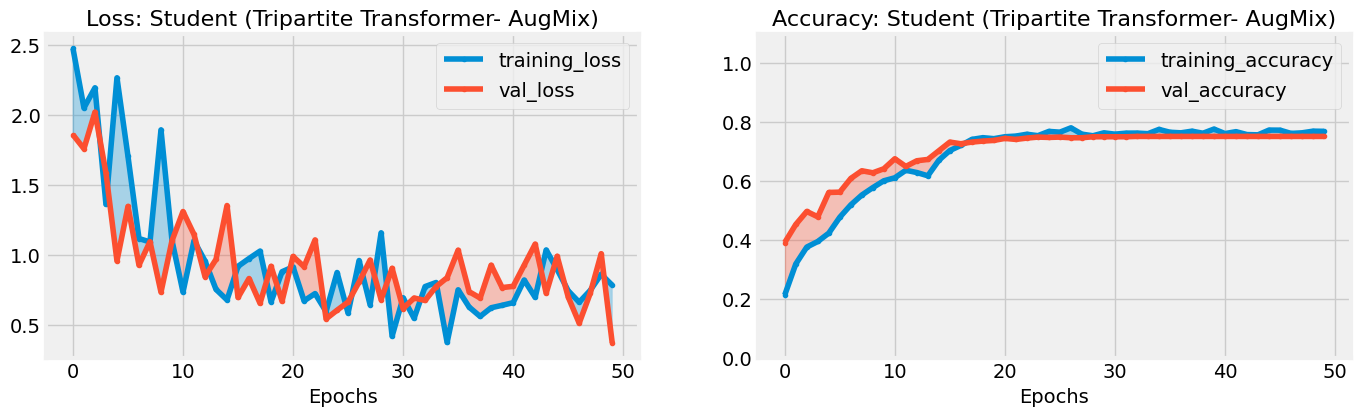

In [ ]:
plot_training_curves(history, 'Student (Tripartite Transformer- AugMix)', model_name='student')

### ▶ CutMix







In [ ]:
history = run_experiment(cutmix_ds, val_ds_v, transformer_teacher, model_name='teacher')

Epoch 1/100
111/111 [==============================] - 55s 297ms/step - loss: 7.7320 - accuracy: 0.1648 - top5-acc: 0.4977 - Brier score: 42.9489 - auc: 0.6052 - val_loss: 2.2762 - val_accuracy: 0.2978 - val_top5-acc: 0.6908 - val_Brier score: 1.6594 - val_auc: 0.7566 - lr: 0.0010
Epoch 2/100
111/111 [==============================] - 32s 273ms/step - loss: 2.9334 - accuracy: 0.2206 - top5-acc: 0.5660 - Brier score: 6.0304 - auc: 0.6368 - val_loss: 2.1673 - val_accuracy: 0.3273 - val_top5-acc: 0.6852 - val_Brier score: 1.4472 - val_auc: 0.7617 - lr: 0.0010
Epoch 3/100
111/111 [==============================] - 32s 273ms/step - loss: 2.4862 - accuracy: 0.2344 - top5-acc: 0.6311 - Brier score: 6.2330 - auc: 0.6724 - val_loss: 2.1288 - val_accuracy: 0.2933 - val_top5-acc: 0.7225 - val_Brier score: 1.9300 - val_auc: 0.7722 - lr: 0.0010
Epoch 4/100
111/111 [==============================] - 32s 273ms/step - loss: 2.4251 - accuracy: 0.2602 - top5-acc: 0.6215 - Brier score: 6.0363 - auc: 0.67

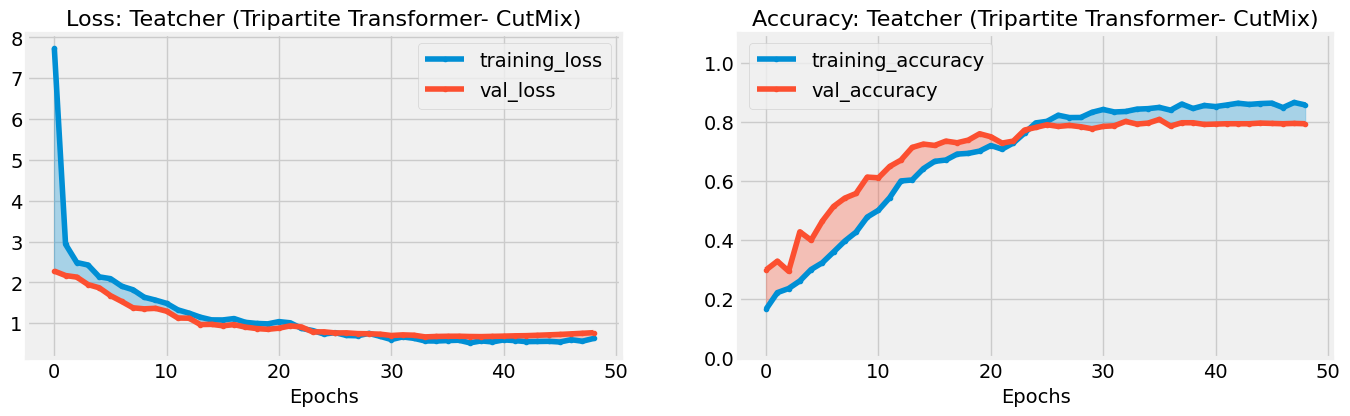

In [ ]:
plot_training_curves(history, 'Teatcher (Tripartite Transformer- CutMix)', model_name='teacher')

In [ ]:
distiller = Distiller(student=transformer_student, teacher=transformer_teacher)
history = run_experiment(cutmix_ds, val_ds_v, distiller, model_name='distiller')

Epoch 1/100
111/111 [==============================] - 54s 254ms/step - accuracy: 0.1571 - top5-acc: 0.5227 - Brier score: 9.0757 - auc: 0.6245 - student_loss: 3.8472 - distillation_loss: 6.2707 - val_accuracy: 0.3511 - val_top5-acc: 0.7667 - val_Brier score: 0.4480 - val_auc: 0.8057 - val_student_loss: 2.3942 - lr: 0.0010
Epoch 2/100
111/111 [==============================] - 27s 227ms/step - accuracy: 0.2520 - top5-acc: 0.6730 - Brier score: 2.5162 - auc: 0.7072 - student_loss: 2.3661 - distillation_loss: 2.9416 - val_accuracy: 0.4077 - val_top5-acc: 0.8403 - val_Brier score: 0.9548 - val_auc: 0.8420 - val_student_loss: 1.6745 - lr: 0.0010
Epoch 3/100
111/111 [==============================] - 27s 227ms/step - accuracy: 0.3131 - top5-acc: 0.7548 - Brier score: 2.8950 - auc: 0.7401 - student_loss: 2.1589 - distillation_loss: 2.7239 - val_accuracy: 0.4994 - val_top5-acc: 0.8935 - val_Brier score: 1.2342 - val_auc: 0.8746 - val_student_loss: 2.0223 - lr: 0.0010
Epoch 4/100
111/111 [====

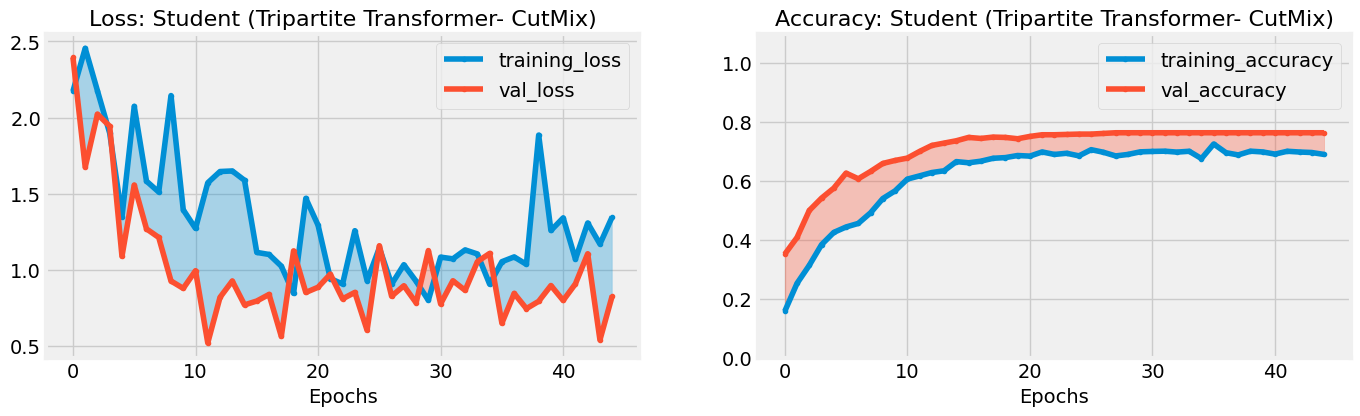

In [ ]:
plot_training_curves(history, 'Student (Tripartite Transformer- CutMix)', model_name='student')

### ▶ MixUp







In [ ]:
history = run_experiment(mixup_ds, val_ds_v, transformer_teacher, model_name='teacher')

Epoch 1/100
111/111 [==============================] - 55s 298ms/step - loss: 7.1426 - accuracy: 0.1770 - top5-acc: 0.5309 - Brier score: 46.1332 - auc: 0.5921 - val_loss: 2.0949 - val_accuracy: 0.3692 - val_top5-acc: 0.7384 - val_Brier score: 1.3506 - val_auc: 0.7835 - lr: 0.0010
Epoch 2/100
111/111 [==============================] - 32s 274ms/step - loss: 2.6909 - accuracy: 0.2837 - top5-acc: 0.6537 - Brier score: 6.9372 - auc: 0.6480 - val_loss: 1.9576 - val_accuracy: 0.4020 - val_top5-acc: 0.7973 - val_Brier score: 1.0843 - val_auc: 0.8268 - lr: 0.0010
Epoch 3/100
111/111 [==============================] - 32s 273ms/step - loss: 2.2212 - accuracy: 0.3644 - top5-acc: 0.7531 - Brier score: 7.5161 - auc: 0.6785 - val_loss: 1.6586 - val_accuracy: 0.5130 - val_top5-acc: 0.8675 - val_Brier score: 1.9916 - val_auc: 0.8583 - lr: 0.0010
Epoch 4/100
111/111 [==============================] - 32s 273ms/step - loss: 1.8909 - accuracy: 0.4148 - top5-acc: 0.8120 - Brier score: 7.3525 - auc: 0.70

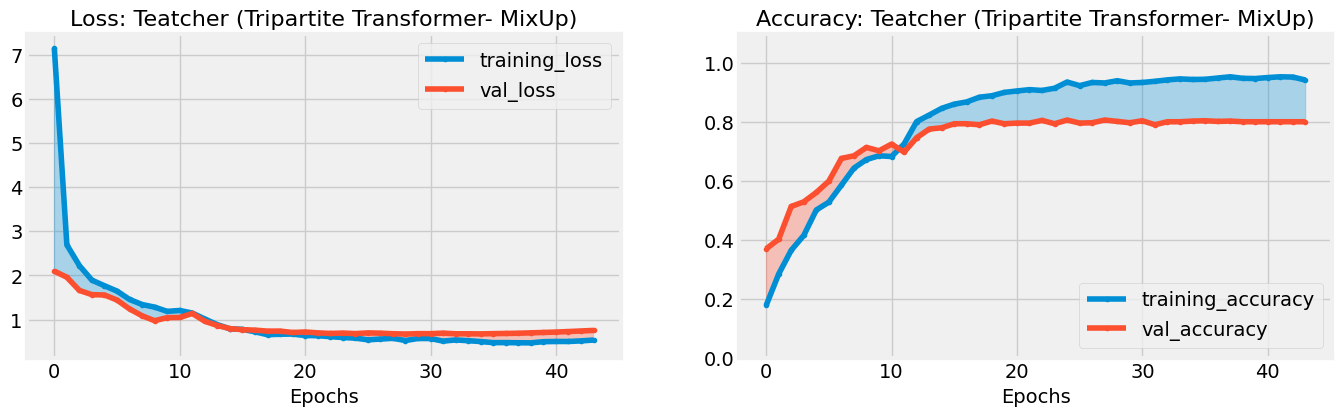

In [ ]:
plot_training_curves(history, 'Teatcher (Tripartite Transformer- MixUp)', model_name='teacher')

In [ ]:
distiller = Distiller(student=transformer_student, teacher=transformer_teacher)
history = run_experiment(mixup_ds, val_ds_v, distiller, model_name='distiller')

Epoch 1/100
111/111 [==============================] - 54s 254ms/step - accuracy: 0.1583 - top5-acc: 0.5215 - Brier score: 12.9661 - auc: 0.6147 - student_loss: 4.1367 - distillation_loss: 6.4138 - val_accuracy: 0.2718 - val_top5-acc: 0.6920 - val_Brier score: 0.2793 - val_auc: 0.7565 - val_student_loss: 2.4706 - lr: 0.0010
Epoch 2/100
111/111 [==============================] - 28s 235ms/step - accuracy: 0.2664 - top5-acc: 0.6744 - Brier score: 2.0977 - auc: 0.6731 - student_loss: 2.4487 - distillation_loss: 2.2391 - val_accuracy: 0.4145 - val_top5-acc: 0.7622 - val_Brier score: 0.3359 - val_auc: 0.8030 - val_student_loss: 2.0963 - lr: 0.0010
Epoch 3/100
111/111 [==============================] - 28s 236ms/step - accuracy: 0.3465 - top5-acc: 0.7517 - Brier score: 2.0842 - auc: 0.7085 - student_loss: 2.1040 - distillation_loss: 1.9048 - val_accuracy: 0.4281 - val_top5-acc: 0.8109 - val_Brier score: 0.6629 - val_auc: 0.8235 - val_student_loss: 2.0225 - lr: 0.0010
Epoch 4/100
111/111 [===

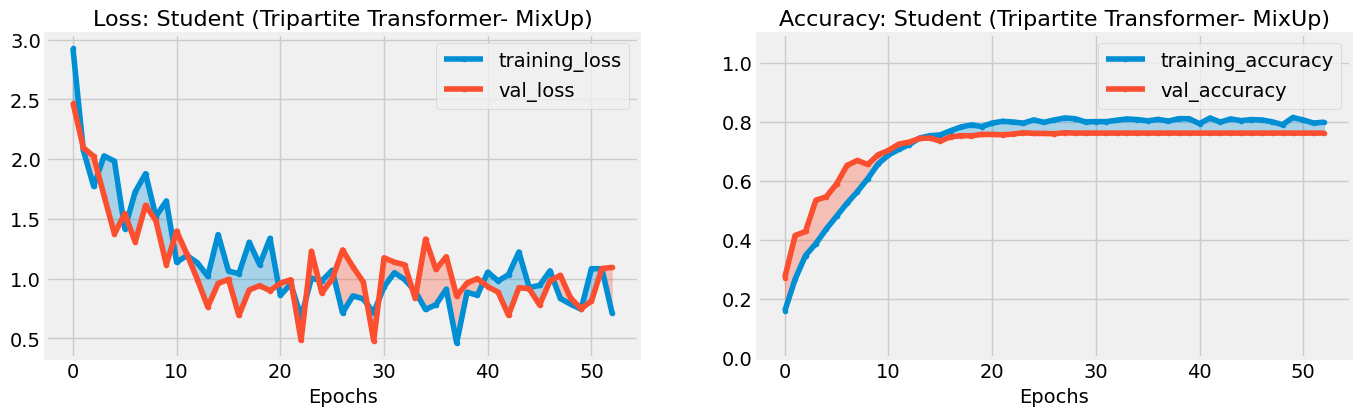

In [ ]:
plot_training_curves(history, 'Student (Tripartite Transformer- MixUp)', model_name='student')

### ▶ AugPip







In [ ]:
history = run_experiment(augpip_ds, val_ds_v, transformer_teacher, model_name='teacher')

Epoch 1/100
111/111 [==============================] - 100s 696ms/step - loss: 7.1333 - accuracy: 0.0991 - top5-acc: 0.3933 - Brier score: 36.6616 - auc: 0.5430 - val_loss: 2.9577 - val_accuracy: 0.1325 - val_top5-acc: 0.4485 - val_Brier score: 1.2952 - val_auc: 0.6165 - lr: 0.0010
Epoch 2/100
111/111 [==============================] - 80s 698ms/step - loss: 2.9404 - accuracy: 0.1096 - top5-acc: 0.4318 - Brier score: 1.5452 - auc: 0.5614 - val_loss: 2.4051 - val_accuracy: 0.2525 - val_top5-acc: 0.6217 - val_Brier score: 1.0024 - val_auc: 0.7196 - lr: 0.0010
Epoch 3/100
111/111 [==============================] - 80s 698ms/step - loss: 2.7588 - accuracy: 0.1317 - top5-acc: 0.4459 - Brier score: 1.2614 - auc: 0.5722 - val_loss: 2.4047 - val_accuracy: 0.2525 - val_top5-acc: 0.6455 - val_Brier score: 0.6772 - val_auc: 0.7199 - lr: 0.0010
Epoch 4/100
111/111 [==============================] - 80s 700ms/step - loss: 2.5951 - accuracy: 0.1634 - top5-acc: 0.5040 - Brier score: 1.6986 - auc: 0.5

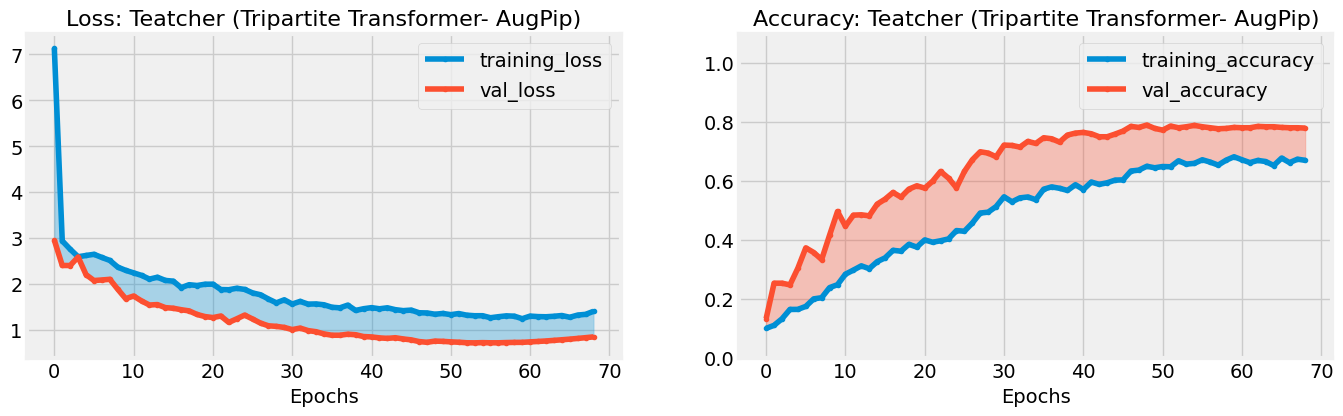

In [ ]:
plot_training_curves(history, 'Teatcher (Tripartite Transformer- AugPip)', model_name='teacher')

In [ ]:
distiller = Distiller(student=transformer_student, teacher=transformer_teacher)
history = run_experiment(augpip_ds, val_ds_v, distiller, model_name='distiller')

Epoch 1/100
111/111 [==============================] - 98s 642ms/step - accuracy: 0.1215 - top5-acc: 0.4595 - Brier score: 8.4342 - auc: 0.5863 - student_loss: 3.7669 - distillation_loss: 3.8488 - val_accuracy: 0.2299 - val_top5-acc: 0.6535 - val_Brier score: 0.1618 - val_auc: 0.7378 - val_student_loss: 2.4599 - lr: 0.0010
Epoch 2/100
111/111 [==============================] - 79s 689ms/step - accuracy: 0.1659 - top5-acc: 0.5674 - Brier score: 1.0773 - auc: 0.6401 - student_loss: 2.5976 - distillation_loss: 1.1075 - val_accuracy: 0.3239 - val_top5-acc: 0.7758 - val_Brier score: 0.2438 - val_auc: 0.7981 - val_student_loss: 2.5208 - lr: 0.0010
Epoch 3/100
111/111 [==============================] - 79s 689ms/step - accuracy: 0.2067 - top5-acc: 0.6577 - Brier score: 1.0370 - auc: 0.6601 - student_loss: 2.4529 - distillation_loss: 0.9511 - val_accuracy: 0.4315 - val_top5-acc: 0.8301 - val_Brier score: 0.3847 - val_auc: 0.8366 - val_student_loss: 2.0435 - lr: 0.0010
Epoch 4/100
111/111 [====

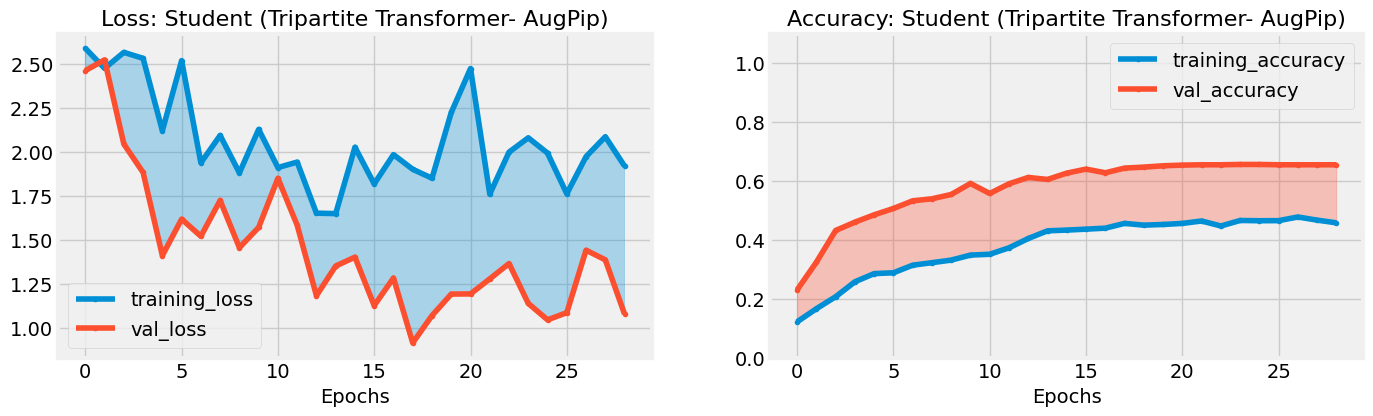

In [ ]:
plot_training_curves(history, 'Student (Tripartite Transformer- AugPip)', model_name='student')

### ▶ AugPip v2







In [ ]:
##### NEW ########
import random
def aug_pipeline_v2(samples):
    samples = augmix(samples, training=True)
    r = random.randint(0, 1)
    if(r>0.5):
      samples = mixup(samples, training=True)
    else:
      samples = cutmix(samples, training=True)
    return samples
#AugPip
augpip_ds_v2 = train_ds.shuffle(1000).map(to_dict)
augpip_ds_v2 = augpip_ds_v2.map(aug_pipeline_v2)
augpip_ds_v2 = augpip_ds_v2.map(preprocess_for_model, num_parallel_calls=AUTOTUNE)
augpip_ds_v2 = augpip_ds_v2.prefetch(AUTOTUNE) #Use this for fit

In [ ]:
history = run_experiment(augpip_ds_v2, val_ds_v, transformer_teacher, model_name='teacher')

Epoch 1/100
111/111 [==============================] - 100s 745ms/step - loss: 3.3561 - accuracy: 0.1413 - top5-acc: 0.4663 - Brier score: 4.7157 - auc: 0.5814 - val_loss: 2.6111 - val_accuracy: 0.1631 - val_top5-acc: 0.3986 - val_Brier score: 1.1632 - val_auc: 0.5742 - lr: 0.0010
Epoch 2/100
111/111 [==============================] - 77s 676ms/step - loss: 2.8440 - accuracy: 0.1424 - top5-acc: 0.4547 - Brier score: 2.8613 - auc: 0.5716 - val_loss: 2.4765 - val_accuracy: 0.2186 - val_top5-acc: 0.5277 - val_Brier score: 1.7230 - val_auc: 0.6703 - lr: 0.0010
Epoch 3/100
111/111 [==============================] - 77s 672ms/step - loss: 2.6847 - accuracy: 0.1685 - top5-acc: 0.5028 - Brier score: 4.9881 - auc: 0.5913 - val_loss: 2.4408 - val_accuracy: 0.2356 - val_top5-acc: 0.5651 - val_Brier score: 1.3544 - val_auc: 0.6770 - lr: 0.0010
Epoch 4/100
111/111 [==============================] - 77s 671ms/step - loss: 2.5865 - accuracy: 0.1883 - top5-acc: 0.5343 - Brier score: 4.9241 - auc: 0.60

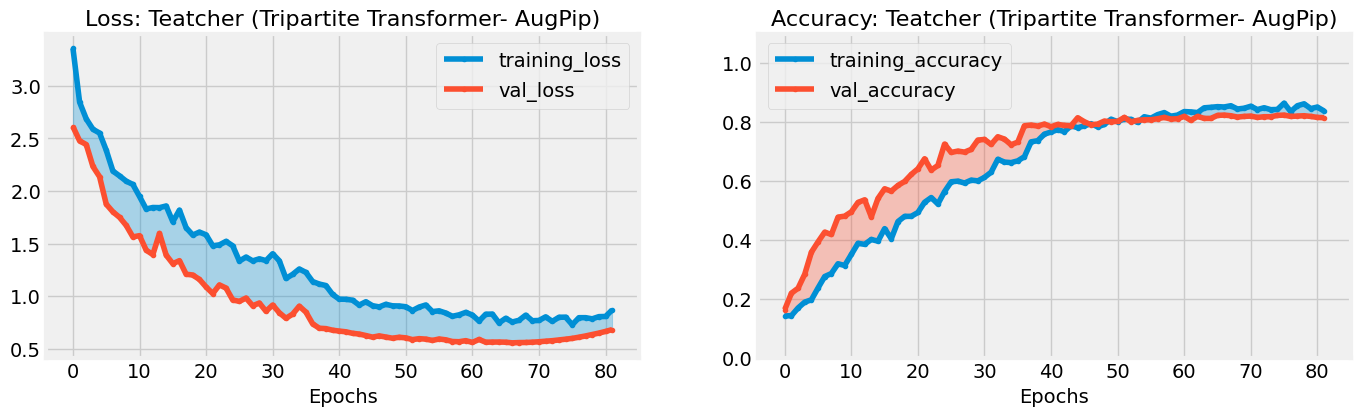

In [ ]:
plot_training_curves(history, 'Teatcher (Tripartite Transformer- AugPip)', model_name='teacher')

In [ ]:
distiller = Distiller(student=transformer_student, teacher=transformer_teacher)
history = run_experiment(augpip_ds_v2, val_ds_v, distiller, model_name='distiller')

Epoch 1/100
111/111 [==============================] - 94s 606ms/step - accuracy: 0.1441 - top5-acc: 0.4841 - Brier score: 7.8657 - auc: 0.6011 - student_loss: 3.8694 - distillation_loss: 4.8957 - val_accuracy: 0.2616 - val_top5-acc: 0.7146 - val_Brier score: 0.2198 - val_auc: 0.7768 - val_student_loss: 2.4313 - lr: 0.0010
Epoch 2/100
111/111 [==============================] - 75s 659ms/step - accuracy: 0.2302 - top5-acc: 0.6257 - Brier score: 1.6394 - auc: 0.6631 - student_loss: 2.4598 - distillation_loss: 1.7604 - val_accuracy: 0.3533 - val_top5-acc: 0.8279 - val_Brier score: 0.6327 - val_auc: 0.8260 - val_student_loss: 2.0407 - lr: 0.0010
Epoch 3/100
111/111 [==============================] - 75s 650ms/step - accuracy: 0.2908 - top5-acc: 0.7095 - Brier score: 1.7385 - auc: 0.6907 - student_loss: 2.2607 - distillation_loss: 1.5372 - val_accuracy: 0.4757 - val_top5-acc: 0.8573 - val_Brier score: 0.6759 - val_auc: 0.8557 - val_student_loss: 1.7345 - lr: 0.0010
Epoch 4/100
111/111 [====

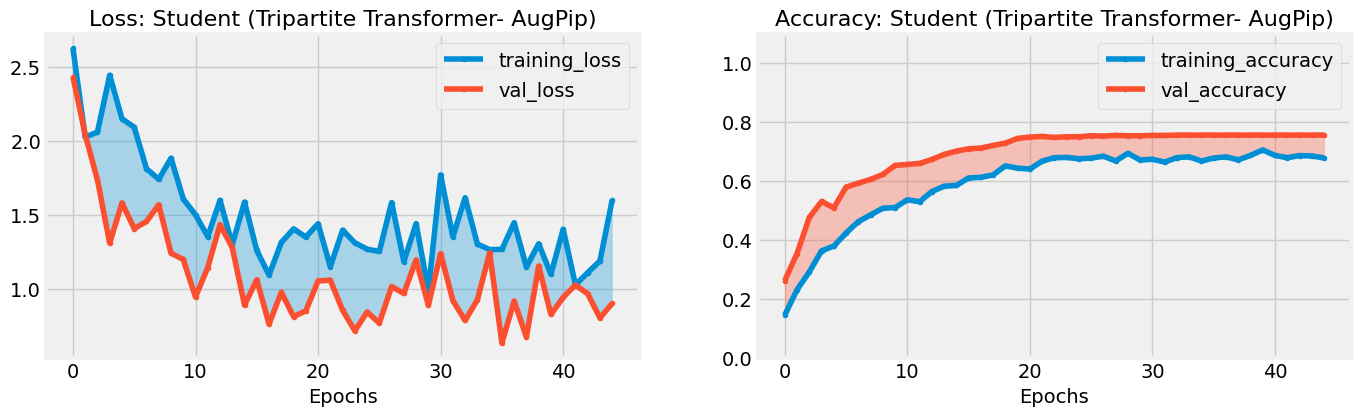

In [ ]:
plot_training_curves(history, 'Student (Tripartite Transformer- AugPip)', model_name='student')



---

